## Imports and Setup

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm

In [ ]:
content_path = '/notebooks'
data_path = './data/'
content_path = Path(content_path)

In [ ]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'VAE/'):
    os.makedirs(content_path/'VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Set random seed
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

## GAN

### Data Loading

In [4]:
mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'GAN'):
    os.makedirs(content_path/'GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


#### Data loading

In [5]:
#!pip install ipywidgets 
#rom ipywidgets import FloatProgress
batch_size = 128 # change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),                        
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


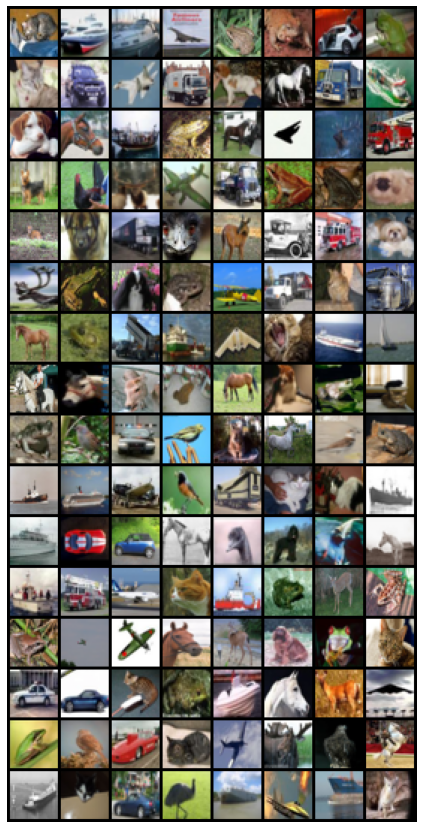

In [6]:
# Visualize some of the test set images
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

### Hyperparameters

In [7]:
num_epochs = 40
learning_rate_d = .0002
learning_rate_g = .0002
latent_vector_size = 100
beta1 = 0.5                 # For optimizers
K = 3                       # How many iterations of the discriminator we train for each iteration of the generator

### Model 

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1)
        )

    def forward(self, z):
        # Reconstructing data
        out = z.view(-1, 100, 1, 1) # reshape to 100 channels, 1x1 'image'
        out = self.generator(out)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size = 4, stride=2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size = 4, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size = 4, stride = 1, padding = 0)
        )

    def forward(self, x):
        out = self.discriminator(x)
        out = out.flatten()
        return out


In [9]:
# Initialize weights of netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 12660355
Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


Total number of parameters in Discriminator is: 11038081
Discriminator(
  (

### Training

In [14]:
# Define a loss function
def loss_function(out, label):
    fn = nn.BCEWithLogitsLoss()
    loss = fn(out, label)
    return loss

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

# For logging
train_losses_G = []
train_losses_D = []

# Label designations
real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))

for epoch in range(num_epochs):
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            # We follow the pytorch DCGAN tutorial training loop implementation: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            for j in range(K):

                model_D.zero_grad()
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                
                # Train with real
                labels_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                # Classify real batch with D
                output = model_D(real_cpu).view(-1)
                # Calculate D loss on real image batch
                loss_D_real = loss_function(output, labels_real) 
                # Calculate gradients for D 
                loss_D_real.backward()
                D_x = output.mean().item()

                # Train with fake
                # Generate random latent vectors
                noise = torch.randn(b_size, 100, 1, 1, device=device)
                # Generate fake image batch with G
                fake = model_G(noise)
                labels_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
                # Classify fake batch with D
                output = model_D(fake.detach()).view(-1)
                # Calculate D loss on fake image batch generated by G
                loss_D_fake = loss_function(output, labels_fake)
                # Calculate gradients for D
                loss_D_fake.backward()
                D_G_z1 = output.mean().item()

                # Calculate total D loss as sum over the fake and the real batches
                loss_D = loss_D_real + loss_D_fake
                # Update the parameters of D using the gradients 
                optimizerD.step()

                # Increase epoch loss 
                train_loss_D = train_loss_D + loss_D.item()

            
            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()
            labels_real = torch.full((b_size,), real_label, dtype=torch.float, device=device) 
            # Calculate G loss based on discriminator output
            output = model_D(fake).view(-1)
            loss_G = loss_function(output, labels_real)
            # Calculate gradients for G
            loss_G.backward()
            D_G_z2 = output.mean().item()
            # Update the parameters of D using the gradients 
            optimizerG.step()

            # Increase epoch loss
            train_loss_G = train_loss_G + loss_G.item()

            # Logging 
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=train_loss_D, Loss_G=train_loss_G)

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), content_path/'CW_GAN/fake_samples_epoch_%03d.png')# % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    
# save  models 
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'GAN/GAN_D_model.pth')

Epoch 39: 100%|██████████| 391/391 [04:28<00:00,  1.45batch/s, D_G_z=-4.514/-5.971, D_x=6.79, Loss_D=0.0906, Loss_G=5.98]


## Generator Images

/opt/conda/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


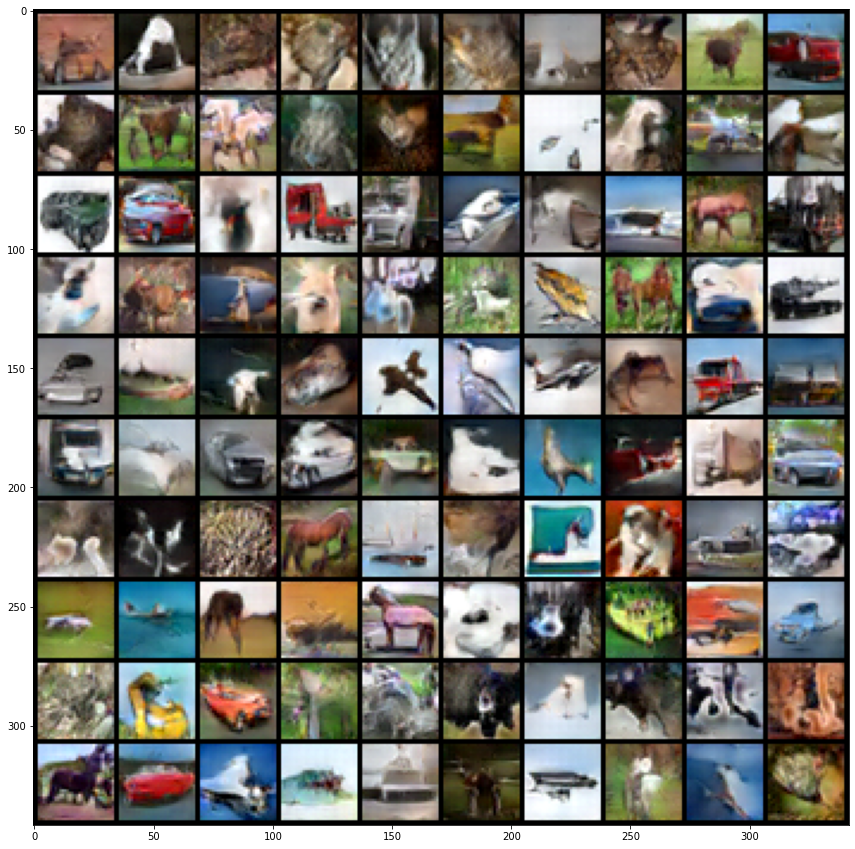

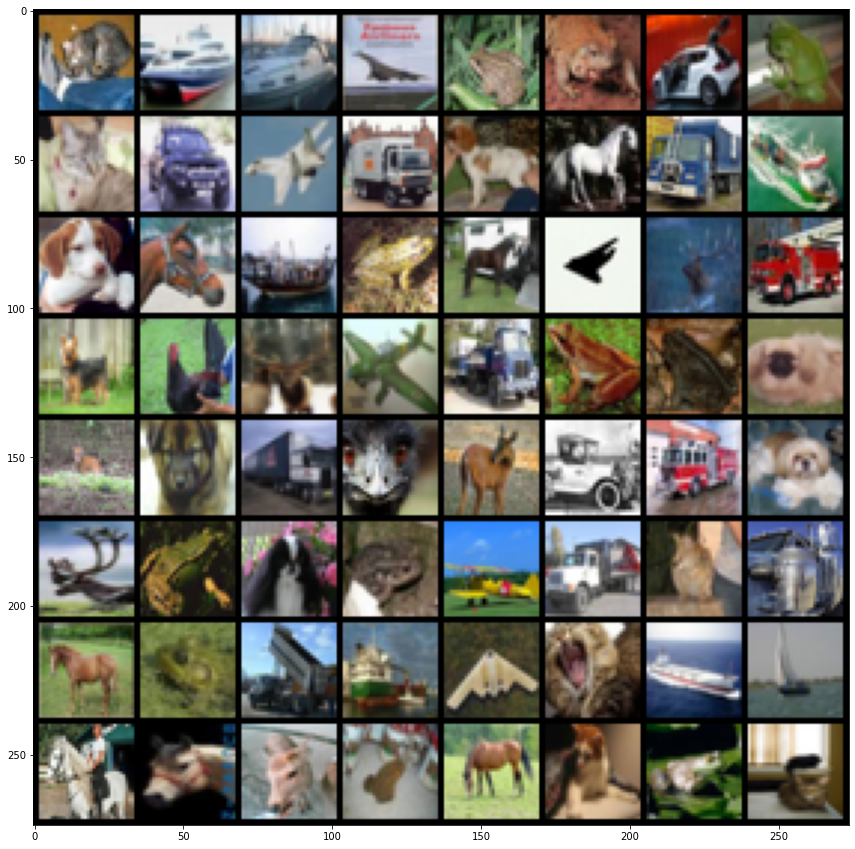

In [16]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) 

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]

# visualize original images
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

Text(0.5, 0.98, 'D Loss')

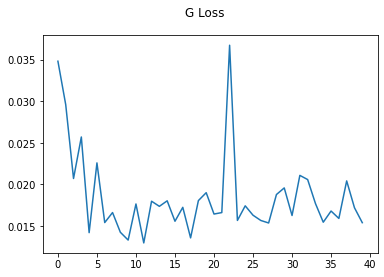

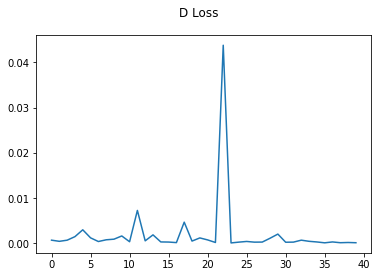

In [17]:
# ANSWER FOR PART 2.2 IN THIS CELL*
# Loss for Training
plt.figure()
plt.plot(train_losses_G)
plt.suptitle('G Loss')

plt.figure()
plt.plot(train_losses_D)
plt.suptitle("D Loss")

